In [2]:
import os
# os.environ['DEVICE_ID'] = '4'
import csv
import numpy as np

import mindspore as ms
from mindspore import context
from mindspore import nn
from mindspore.ops import operations as P
from mindspore.ops import functional as F

context.set_context(device_target="Ascend")


In [3]:
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

--2023-03-23 15:36:24--  http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving proxy.modelarts.com (proxy.modelarts.com)... 192.168.6.3
Connecting to proxy.modelarts.com (proxy.modelarts.com)|192.168.6.3|:80... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10782 (11K) [application/x-httpd-php]
Saving to: ‘wine.data.1’

wine.data.1         100%[===================>]  10.53K  --.-KB/s    in 0s      

2023-03-23 15:36:24 (211 MB/s) - ‘wine.data.1’ saved [10782/10782]



In [4]:
with open('wine.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[56:62]+data[130:133]) # 打印部分数据


[['1', '14.22', '1.7', '2.3', '16.3', '118', '3.2', '3', '.26', '2.03', '6.38', '.94', '3.31', '970'], ['1', '13.29', '1.97', '2.68', '16.8', '102', '3', '3.23', '.31', '1.66', '6', '1.07', '2.84', '1270'], ['1', '13.72', '1.43', '2.5', '16.7', '108', '3.4', '3.67', '.19', '2.04', '6.8', '.89', '2.87', '1285'], ['2', '12.37', '.94', '1.36', '10.6', '88', '1.98', '.57', '.28', '.42', '1.95', '1.05', '1.82', '520'], ['2', '12.33', '1.1', '2.28', '16', '101', '2.05', '1.09', '.63', '.41', '3.27', '1.25', '1.67', '680'], ['2', '12.64', '1.36', '2.02', '16.8', '100', '2.02', '1.41', '.53', '.62', '5.75', '.98', '1.59', '450'], ['3', '12.86', '1.35', '2.32', '18', '122', '1.51', '1.25', '.21', '.94', '4.1', '.76', '1.29', '630'], ['3', '12.88', '2.99', '2.4', '20', '104', '1.3', '1.22', '.24', '.83', '5.4', '.74', '1.42', '530'], ['3', '12.81', '2.31', '2.4', '24', '98', '1.15', '1.09', '.27', '.83', '5.7', '.66', '1.36', '560']]


In [5]:
X = np.array([[float(x) for x in s[1:]] for s in data[:178]], np.float32)
Y = np.array([s[0] for s in data[:178]], np.int32)

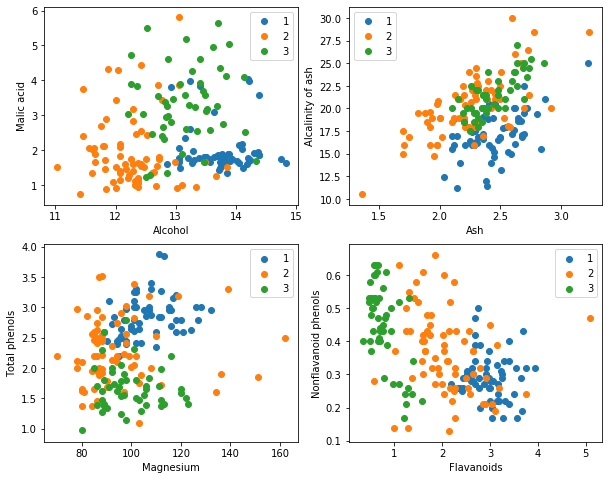

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
attrs = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
         'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
         'OD280/OD315 of diluted wines', 'Proline']
plt.figure(figsize=(10, 8))
for i in range(0, 4):
    plt.subplot(2, 2, i+1)
    a1, a2 = 2 * i, 2 * i + 1
    plt.scatter(X[:59, a1], X[:59, a2], label='1')
    plt.scatter(X[59:130, a1], X[59:130, a2], label='2')
    plt.scatter(X[130:, a1], X[130:, a2], label='3')
    plt.xlabel(attrs[a1])
    plt.ylabel(attrs[a2])
    plt.legend()
plt.show()


In [7]:
train_idx = np.random.choice(178, 128, replace=False)
test_idx = np.array(list(set(range(178)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]


In [8]:
class KnnNet(nn.Cell):
    def __init__(self, k):
        super(KnnNet, self).__init__()
        self.tile = P.Tile()
        self.sum = P.ReduceSum()
        self.topk = P.TopK()
        self.k = k

    def construct(self, x, X_train):
        # Tile input x to match the number of samples in X_train
        x_tile = self.tile(x, (128, 1))
        square_diff = F.square(x_tile - X_train)
        square_dist = self.sum(square_diff, 1)
        dist = F.sqrt(square_dist)
        # -dist mean the bigger the value is, the nearer the samples are
        values, indices = self.topk(-dist, self.k)
        return indices


def knn(knn_net, x, X_train, Y_train):
    x, X_train = ms.Tensor(x), ms.Tensor(X_train)
    indices = knn_net(x, X_train)
    topk_cls = [0]*len(indices.asnumpy())
    for idx in indices.asnumpy():
        topk_cls[Y_train[idx]] += 1
    cls = np.argmax(topk_cls)
    return cls


In [9]:
acc = 0
knn_net = KnnNet(5)
for x, y in zip(X_test, Y_test):
    pred = knn(knn_net, x, X_train, Y_train)
    acc += (pred == y)
    print('label: %d, prediction: %s' % (y, pred))
print('Validation accuracy is %f' % (acc/len(Y_test)))


label: 2, prediction: 3
label: 3, prediction: 3
label: 1, prediction: 1
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 3
label: 3, prediction: 3
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 3
label: 3, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 2
label: 1, prediction: 1
label: 3, prediction: 2
label: 3, prediction: 2
label: 3, prediction: 3
label: 1, prediction: 1
label: 1, prediction: 1
label: 3, prediction: 2
label: 3, prediction: 3
label: 3, prediction: 3
label: 1, prediction: 1
label: 3, prediction: 2
label: 1, prediction: 1
label: 3, prediction: 1
label: 3, prediction: 2
label: 1, prediction: 1
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 1
label: 2, prediction: 1
label: 2, prediction: 3
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 2
label: 2, prediction: 3
label: 2, prediction: 2
label: 2, predic